In [340]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
#!pip install sweetviz
import sweetviz as sv

## 1. Importación del dataset sin nulls ni outliers

Del EDA del anterior Sprint, importaremos el dataset que ya no tenía registros nulos, no tampoco outliers extremos por la característica balance.

In [341]:
df_bank = pd.read_csv('df_bank_filled.csv',delimiter=";")
df_bank.head()

,job,default,balance,housing,loan,contact,day,month,duration,campaign,...,index_temp,age,marital,education,duration_min,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23
0,admin.,0,2343,1,0,unknown,5,may,1042,1,...,0,59,married,secondary,17.4,NaN,NaN,NaN,NaN,NaN
1,admin.,0,45,0,0,unknown,5,may,1467,1,...,1,56,married,secondary,24.4,NaN,NaN,NaN,NaN,NaN
2,technician,0,1270,1,0,unknown,5,may,1389,1,...,2,41,married,secondary,23.2,NaN,NaN,NaN,NaN,NaN
3,services,0,2476,1,0,unknown,5,may,579,1,...,3,55,married,secondary,9.6,NaN,NaN,NaN,NaN,NaN
4,admin.,0,184,0,0,unknown,5,may,673,2,...,4,54,married,tertiary,11.2,NaN,NaN,NaN,NaN,NaN


In [342]:
#Eliminamos columnas del csv que nod eberían haberse importado
df_bank=df_bank.drop(["Unnamed: 19","Unnamed: 20","Unnamed: 21","Unnamed: 22","Unnamed: 23"],axis=1)


Para verificar que no tenemos ningún null

In [343]:
df_bank.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10650 entries, 0 to 10649
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   job           10650 non-null  object 
 1   default       10650 non-null  int64  
 2   balance       10650 non-null  int64  
 3   housing       10650 non-null  int64  
 4   loan          10650 non-null  int64  
 5   contact       10650 non-null  object 
 6   day           10650 non-null  int64  
 7   month         10650 non-null  object 
 8   duration      10650 non-null  int64  
 9   campaign      10650 non-null  int64  
 10  pdays         10650 non-null  int64  
 11  previous      10650 non-null  int64  
 12  poutcome      10650 non-null  object 
 13  deposit       10650 non-null  int64  
 14  index_temp    10650 non-null  int64  
 15  age           10650 non-null  int64  
 16  marital       10650 non-null  object 
 17  education     10650 non-null  object 
 18  duration_min  10650 non-nu

Para verificar los valores distintos de las tres categorías que tenían null en el Sprint anterior. 

In [344]:
columns=["job","marital","education"]

for col in columns:
    print(f"Valores distintos de {col}")
    print("\n",df_bank[col].value_counts())


Valores distintos de job

 job
management       2403
blue-collar      1891
technician       1723
admin.           1295
services          902
retired           724
self-employed     384
student           345
unemployed        340
entrepreneur      314
housemaid         264
unknown            65
Name: count, dtype: int64
Valores distintos de marital

 marital
married     6047
single      3360
divorced    1243
Name: count, dtype: int64
Valores distintos de education

 education
secondary    5629
tertiary     3541
primary      1480
Name: count, dtype: int64


## 2. Preprocesamiento de las características

In [345]:
### 2.1 Creacion de variables de interacción con marital y education

In [346]:
#df_bank.loc[:,'marital_education']=df_bank['marital']+"_"+df_bank['education']
#df_bank['marital_education'].unique()

### 2.1 Disminución de categorias por característica

**Disminución de categorías month por estaciones**

In [347]:
recod={'jan':'invierno','feb':'invierno','mar':'invierno','apr':'primavera','may':'primavera','jun':'primavera','jul':'verano','aug':'verano','sep':'verano','oct':'otoño','nov':'otoño','dec':'otoño'}
df_bank.loc[:,'estacion']=df_bank.loc[:,'month'].map(recod)
df_bank['estacion'].unique()

array(['primavera', 'verano', 'otoño', 'invierno'], dtype=object)

**Disminución de categorías poutcome**

In [348]:
df_bank['poutcome'].unique()

array(['unknown', 'other', 'failure', 'success'], dtype=object)

In [349]:
recod={'unknown':'other','other':'other','failure':'failure','success':'success'}
df_bank.loc[:,'cat_poutcome']=df_bank.loc[:,'poutcome'].map(recod)
df_bank.loc[:,'cat_poutcome'].unique()

array(['other', 'failure', 'success'], dtype=object)

**Combinación de categorias para datos como job de alta cardinalidad**

In [350]:
categ_job={'management':'trabajo técnico','technician':'trabajo técnico','admin.':'trabajo técnico','blue-collar':'trabajo operativo','services':'trabajo operativo','self-employed':'empresario','entrepreneur':'empresario',
           'unemployed':'sin cotizar','student':'sin cotizar','retired':'sin cotizar','housemaid':'sin cotizar','unknown':'sin cotizar'}

df_bank.loc[:,'cat_job']=df_bank.loc[:,'job'].map(categ_job)
df_bank['cat_job'].unique()

array(['trabajo técnico', 'trabajo operativo', 'sin cotizar',
       'empresario'], dtype=object)

Con esta estrategia de categorización, hemos pasado de tener 12 tipologías de job a 4, que será mucho más manejable. Hemos asimilidado los unknown que son solo 65 registros a 'sin cotizar'

### 2.2 Binning de variables numéricas

De momento mantenemos este apartado, aunque es muy probable que no utilizaremos estas variables en la preselección como se verá.

**Binning de característica balance**

In [351]:
#Primera estrategia para que esten más equilibrados el número de registros por rango. 
balance_q4=df_bank['balance'].quantile(0.4)
balance_q7=df_bank['balance'].quantile(0.7)
min_balance=round(df_bank['balance'].min(),0)
max_balance=round(df_bank['balance'].max(),0)


label_balance=['saldo negativo', 'saldo bajo', 'saldo medio', 'saldo alto']
df_bank.loc[:,'rango_balance'] = pd.cut(df_bank['balance'], bins=[min_balance, 0, balance_q4, balance_q7, max_balance], labels=label_balance, include_lowest=True)
df_bank['rango_balance'].unique()

['saldo alto', 'saldo bajo', 'saldo negativo', 'saldo medio']
Categories (4, object): ['saldo negativo' < 'saldo bajo' < 'saldo medio' < 'saldo alto']

Como hay ordinalidad en los rangos de balance, podemos realizar la codificación por etiquetas (label encoding) (por enteros crecientes), siendo el saldo más bajo, el número más bajo.

In [352]:
#Como hay ordinalidad en los rangos de balance, podemos realizar la codificación por etiquetas (label encoding), siendo el saldo más bajo, el número más bajo, el 1.
recod={'saldo negativo':1, 'saldo bajo':2, 'saldo medio':3, 'saldo alto':4}
df_bank.loc[:,'recod_rango_balance']=df_bank['rango_balance'].map(recod)

**Binning de característica age**

In [353]:
age_q33=round(df_bank['age'].quantile(0.33))
age_q66=round(df_bank['age'].quantile(0.66))
age_min=round(df_bank['age'].min(),0)
age_max=round(df_bank['age'].max(),0)

label_age=['edad baja', 'edad media', 'edad alta']
df_bank.loc[:,'rango_age'] = pd.cut(df_bank['age'], bins=[0, age_q33, age_q66, age_max], labels=label_age, include_lowest=True)

#Después del binning aplicamos un label encoding, pues hay ordinalidad en las categorías de las edades.
recod={'edad baja':1, 'edad media':2, 'edad alta':3}
df_bank.loc[:,'recod_rango_age']=df_bank['rango_age'].map(recod)

**Binning de característica duration**

In [354]:
duration_q33=round(df_bank['duration_min'].quantile(0.33),1)
duration_q66=round(df_bank['duration_min'].quantile(0.66),1)
duration_min=round(df_bank['duration_min'].min(),1)
duration_max=round(df_bank['duration_min'].max(),1)

label_age=['duracion baja', 'duracion media', 'duracion alta']
df_bank.loc[:,'rango_duration'] = pd.cut(df_bank['duration_min'], bins=[0, duration_q33, duration_q66, duration_max], labels=label_age, include_lowest=True)

#Después del binning aplicamos un label encoding, pues hay ordinalidad en las categorías de las duraciones.
recod={'duracion baja':1, 'duracion media':2, 'duracion alta':3}
df_bank.loc[:,'recod_duration_min']=df_bank['rango_duration'].map(recod)

### 2.3 Kmeans para encontrar agrupaciones nuevas 

Esto lo hacemos ya que nos lo habíamos propuesto como objetivo en nuestro modelo, aunque como veremos al final no utilizaremos esta característica nueva

In [355]:
df_bank.head()

,job,default,balance,housing,loan,contact,day,month,duration,campaign,...,duration_min,estacion,cat_poutcome,cat_job,rango_balance,recod_rango_balance,rango_age,recod_rango_age,rango_duration,recod_duration_min
0,admin.,0,2343,1,0,unknown,5,may,1042,1,...,17.4,primavera,other,trabajo técnico,saldo alto,4,edad alta,3,duracion alta,3
1,admin.,0,45,0,0,unknown,5,may,1467,1,...,24.4,primavera,other,trabajo técnico,saldo bajo,2,edad alta,3,duracion alta,3
2,technician,0,1270,1,0,unknown,5,may,1389,1,...,23.2,primavera,other,trabajo técnico,saldo alto,4,edad media,2,duracion alta,3
3,services,0,2476,1,0,unknown,5,may,579,1,...,9.6,primavera,other,trabajo operativo,saldo alto,4,edad alta,3,duracion alta,3
4,admin.,0,184,0,0,unknown,5,may,673,2,...,11.2,primavera,other,trabajo técnico,saldo bajo,2,edad alta,3,duracion alta,3


In [356]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

#Hacemos un label encoding, tal como nos recomendó la profesora Verónica
dic_recod={'primary':1,'secondary':2,'tertiary':3}
df_bank['recod_education']=df_bank['education'].map(dic_recod).astype(int)

#Hacemos one-hot-encoding para marital y cat_job
df_encoded = pd.get_dummies(df_bank, columns=['marital','cat_job'])

data_num=df_bank[['recod_education','recod_rango_age']]
#X = df_encoded[['new_balance'] + [col for col in df_encoded.columns if col.startswith('marital_') or col.startswith('education_')]]

# Estandarizamos las variables numéricas
scaler = StandardScaler()
datanum_scaled = scaler.fit_transform(data_num)
X_scaled=pd.DataFrame(datanum_scaled,columns=['recod_education','recod_rango_age'],index=data_num.index)


#Ahora concatenamos las variables estandarizadas numéricas con las variables categóricas que no teníamos que aplicar escalado
X_scaled_aux=pd.concat(
    [X_scaled, df_encoded[[col for col in df_encoded.columns if col.startswith('marital') or col.startswith('cat_job')]]],
    axis=1)

#Tenemos que convertir X_scaled a variable numpy.array ya que sinó no funcionaría Kmeans
X_scaled_np=X_scaled_aux.to_numpy()


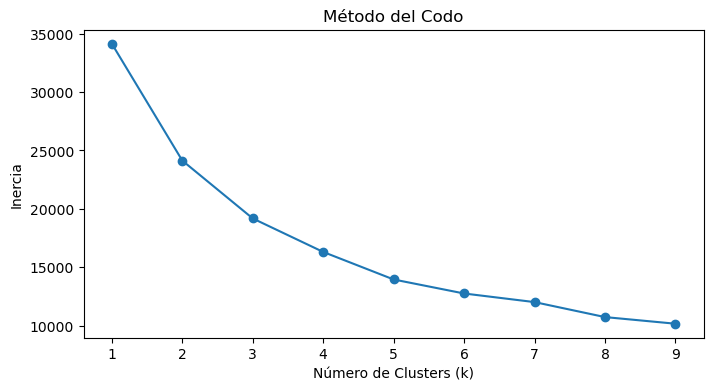

In [357]:
# Aplicamos el método del codo para determinar el número óptimo de clusters
inertia = []
K_range = range(1, 10)  # Probaremos con clusters de 1 a 9

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=0, n_init=10, init='k-means++')
    kmeans.fit(X_scaled_np)
    inertia.append(kmeans.inertia_)

# Graficamos el método del codo
plt.figure(figsize=(8, 4))
plt.plot(K_range, inertia, marker='o')
plt.title('Método del Codo')
plt.xlabel('Número de Clusters (k)')
plt.ylabel('Inercia')
plt.show()

In [ ]:
#7 es un buen número.
k_optimo = 7
kmeans_final = KMeans(n_clusters=k_optimo, random_state=0, n_init=10, init='k-means++')
df_bank['cluster'] = kmeans_final.fit_predict(X_scaled_np)

columns_categ=['education','rango_age','marital','cat_job']
for i in range(k_optimo):
    print(f'El cluster {i}','\n')
    cluster=df_bank['cluster']==i
    for col in columns_categ:
        print(df_bank[cluster][col].value_counts(),'\n')
      


Hemos encontrado 7 clústers, pero no nos centraremos en explicar las características de cada uno, pues al final hemos visto que no nos será útil para introducirla al modelo, pues introduciríamos más incertidumbre, pues esta nueva característica (el cluster), hemos visto que no sería de las que mejor estaría correlacionada con la variable objetivo con el método de Chi-cuadrado.

## 3. Métodos de FILTRO para preselección de características relevantes

### 3.1 Funciones de filtro para características categóricas a variable objetivo categórica

In [359]:
import scipy.stats as stats

#Esta vez definimos una función para evitar pegar cada vez este código
def chi2_entre_categorias(df,x,y):

    contingency_table = pd.crosstab(df[x], df[y])

    # Aplicar la prueba de Chi-cuadrado
    chi2_stat, p_value, dof, expected = stats.chi2_contingency(contingency_table)

    # Imprimir los resultados
    #print("Tabla de Contingencia:")
    #print(contingency_table, "\n")

    #print("Resultados de la Prueba de Chi-cuadrado:")
    #print(f"Estadístico Chi-cuadrado: {chi2_stat}")
    #print(f"P-valor: {p_value}")
    #print(f"Grados de libertad: {dof}")
    #print("Frecuencias esperadas:")
    #print(expected)
    return(p_value,chi2_stat,dof,expected)

In [360]:
df_bank.head()

,job,default,balance,housing,loan,contact,day,month,duration,campaign,...,cat_poutcome,cat_job,rango_balance,recod_rango_balance,rango_age,recod_rango_age,rango_duration,recod_duration_min,recod_education,cluster
0,admin.,0,2343,1,0,unknown,5,may,1042,1,...,other,trabajo técnico,saldo alto,4,edad alta,3,duracion alta,3,2,6
1,admin.,0,45,0,0,unknown,5,may,1467,1,...,other,trabajo técnico,saldo bajo,2,edad alta,3,duracion alta,3,2,6
2,technician,0,1270,1,0,unknown,5,may,1389,1,...,other,trabajo técnico,saldo alto,4,edad media,2,duracion alta,3,2,2
3,services,0,2476,1,0,unknown,5,may,579,1,...,other,trabajo operativo,saldo alto,4,edad alta,3,duracion alta,3,2,4
4,admin.,0,184,0,0,unknown,5,may,673,2,...,other,trabajo técnico,saldo bajo,2,edad alta,3,duracion alta,3,3,1


In [361]:
# Seleccionamos las columnas que consideramos categóricas para aplicar  el método de filtro de chi2 con la variable objetivo binaria
columnas_categoricas=['default','housing','contact','estacion','cat_poutcome','cat_job','rango_balance','rango_age','education','cluster']

lista_chi2_stat=[]
lista_chi2_p_value=[]
lista_chi2_dof=[]
lista_chi2_expected=[]

for column in columnas_categoricas:
   chi2_stat, p_value, dof, expected =chi2_entre_categorias(df_bank,column,'deposit')
   lista_chi2_stat.append(chi2_stat)
   lista_chi2_p_value.append(p_value)
   lista_chi2_dof.append(dof)
   #Si alguna frecuencia fuera inferior a 5 podría no ser válida la prueba Chi2
   lista_chi2_expected.append(np.amin(expected))
   

dic_chi2={'caract_numéricas':columnas_categoricas,'chi2_stat':lista_chi2_stat,'p_value':lista_chi2_p_value,
          'dof':lista_chi2_dof,'expected':lista_chi2_expected}
df_chi2=pd.DataFrame(dic_chi2)
df_chi2.sort_values('p_value',ascending=False)


,caract_numéricas,chi2_stat,p_value,dof,expected
4,cat_poutcome,1.016367e-197,907.186058,2,471.922629
2,contact,1.769393e-149,685.029085,2,338.226854
1,housing,1.810121e-96,434.379471,1,2395.734460
5,cat_job,1.268353e-52,244.047336,3,327.437371
6,rango_balance,1.068194e-51,239.768120,3,685.366761
3,estacion,1.955853e-43,201.544945,3,622.037183
9,cluster,9.201952e-27,135.434906,6,337.288638
8,education,1.966310e-25,113.776937,2,694.279812
7,rango_age,1.875990e-14,63.214110,2,1602.941972
0,default,5.374284e-05,16.311289,1,78.341033


Vemos que en todas las variables tenemos buena significancia (p-valor<0,05), pero cat_poutcome, contact, housing y cat_job destacan por encima de las demás,por ser su p-valor muy pequeño y alta chi2_stat. Ratificamos que clusterizar no nos aportará mucho valor, pues al final entraríamos más incertidumbre al modelo, ya que con nuevos datos, tendríamos que asignarlo a qué clúster pertenecería, introduciendo más posiblidades de errores.

- **cat_poutcome**

- **contact**

- **housing**

- **cat_job**

### 3.2 Funciones de filtro para ver dependencia entre características categorícas

In [362]:
#Solo miramos dependencia entre las características preseleccionadas
columnas_categoricas=['cat_poutcome','contact','housing','cat_job']

lista_chi2_stat=[]
lista_chi2_p_value=[]
lista_chi2_dof=[]
lista_chi2_expected=[]
lista_comb_columnas=[]
for column1 in columnas_categoricas:
   for column2 in columnas_categoricas:
          if column1!=column2:
            p_value,chi2_stat,dof,expected=chi2_entre_categorias(df_bank,column1,column2)
            lista_comb_columnas.append(column1+"_"+column2)
            lista_chi2_stat.append(chi2_stat)
            lista_chi2_p_value.append(p_value)
            lista_chi2_dof.append(dof)
            #Si alguna frecuencia fuera inferior a 5 podría no ser válida la prueba Chi2
            lista_chi2_expected.append(np.amin(expected))
   

dic_chi2={'caract_numéricas':lista_comb_columnas,'chi2_stat':lista_chi2_stat,'p_value':lista_chi2_p_value,
          'dof':lista_chi2_dof,'expected':lista_chi2_expected}
df_chi2=pd.DataFrame(dic_chi2)
pd.set_option('display.max_rows', 100)
df_chi2.sort_values('p_value',ascending=True)



,caract_numéricas,chi2_stat,p_value,dof,expected
8,housing_cat_job,910.741840,4.140339e-197,3,334.712300
11,cat_job_housing,910.741840,4.140339e-197,3,334.712300
4,contact_housing,725.199455,3.349186e-158,2,345.741502
7,housing_contact,725.199455,3.349186e-158,2,345.741502
0,cat_poutcome_contact,717.099399,6.911989e-154,4,68.105728
3,contact_cat_poutcome,717.099399,6.911989e-154,4,68.105728
5,contact_cat_job,502.539491,2.385851e-105,6,47.254272
10,cat_job_contact,502.539491,2.385851e-105,6,47.254272
1,cat_poutcome_housing,241.792839,3.128615e-53,2,482.407700
6,housing_cat_poutcome,241.792839,3.128615e-53,2,482.407700


Vemos que **housing** y **cat_job** estan muy correlacionadas, así que de momento quitaremos cat_job que tiene muchas categorías distintas.
También nos pasa con **contact** y **housing** así que de momento mantendremos **housing**. Finalmente dejaremos como características categóricas:

- **cat_poutcome**
- **housing**

### 3.3 Funciones de filtro para características numéricas a variable objetivo categórica

In [363]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#Aunque la preuba de LDA no la aplicaremos pues las variables numéricas no tienen distribución normal, y es una asumpción.
def lda_entre_categorias(df,x,y):

    # Aplicamos LDA
    lda = LinearDiscriminantAnalysis()

    lda.fit(df[[x]], df[y])
    # Imprimimos la media de cada clase proyectada en el eje discriminante
    print("Orden de las clases en lda.means_:", lda.classes_)
    print("Medias de cada clase proyectadas en el eje discriminante:", lda.means_)
    print("Coeficiente de separación (coeficientes de la proyección):", lda.coef_)
    std_x=df['balance'].std()
    print("Desviación estándar balance:", x)
    return (lda.means_,lda.coef_,std_x)

In [364]:
from scipy.stats import ttest_ind
#Aunque la preuba de t-student no la aplicaremos pues las variables numéricas no tienen distribución normal, y es una asumpción.
def prueba_t (df,x,y):
    
    # Dividimos los datos en dos grupos según el valor de la variable binaria
    group_1=df[df[y]==1][x]
    group_0=df[df[y]==0][x]

    # Realizamos la prueba T
    t_stat, p_value = ttest_ind(group_1, group_0)
    # Resultados
    #print("Estadístico t:", t_stat)
    #print("Valor p:", p_value)  
    return (t_stat,p_value)


In [365]:
from scipy.stats import mannwhitneyu

def mann_white (df,x,y):
    
    # Dividimos los datos en dos grupos según el valor de la variable binaria
    group_1=df[df[y]==1][x]
    group_0=df[df[y]==0][x]

    # Realizamos la prueba T
    u_stat, p_value = ttest_ind(group_1, group_0)
    # Resultados
    #print("Estadístico t:", t_stat)
    #print("Valor p:", p_value)  
    return (u_stat,p_value)


In [366]:
from scipy.stats import pointbiserialr
def correl_biserial (df,x,y):

    correl, p_value = pointbiserialr(df[x], df[y])  
    # Resultados
    #print("Correlación biserial puntual:", correl)
    #print("Valor p:", p_value)
    return (correl,p_value)



In [367]:
# Seleccionamos las columnas que consideramos numéricas continuas para aplicar  el método de filtro
columnas_numericas =df_bank.select_dtypes(include=['number']).columns.tolist()

#Excluiremos además 'duration' pues segun las asumpición de la web de bank_marketing no podrá utilizarse como predictora
to_remove=['default','housing','loan','deposit','index_temp','duration','duration_min','cluster']
for item in df_bank.columns:
    if item in to_remove:
       columnas_numericas.remove(item)

columnas_numericas

['balance', 'day', 'campaign', 'pdays', 'previous', 'age', 'recod_education']

**Método de filtro mann_white entre numéricas y variable categórica depósito**

Este método lo podemos aplicar, porque no es necesario que las variables numéricas tengan una distribución normal, que es nuestro caso. También hemos considerado variables numéricas aquellas de valor entero, y que tienen bastantes valores distintos.

In [368]:
lista_u_stat=[]
lista_u_p_value=[]

for column in columnas_numericas:
   u_stat,p_value=mann_white(df_bank,column,'deposit')
   lista_u_stat.append(u_stat)
   lista_u_p_value.append(p_value)

dic_df_mann_white={'caract_numéricas':columnas_numericas,'u_stat':lista_u_stat,'p_value':lista_u_p_value}
df_mann_white=pd.DataFrame(dic_df_mann_white)
df_mann_white.sort_values('p_value',ascending=True)

,caract_numéricas,u_stat,p_value
3,pdays,15.639033,1.591966e-54
4,previous,14.714813,1.549782e-48
0,balance,13.340411,2.833989e-40
2,campaign,-13.264471,7.697635e-40
6,recod_education,10.641254,2.596338e-26
1,day,-5.614205,2.024136e-08
5,age,3.119214,1.818182e-03


Con esta prueba todas las numéricas tendrían significancia es decir que cambia significativamente las frecuencias en función de la classificación. Eso sí escogeremos solo que pdays, previous, balance y campaign tendrían significancia muy superior a day y age.

**Buscar colinealidad entre características numéricas**

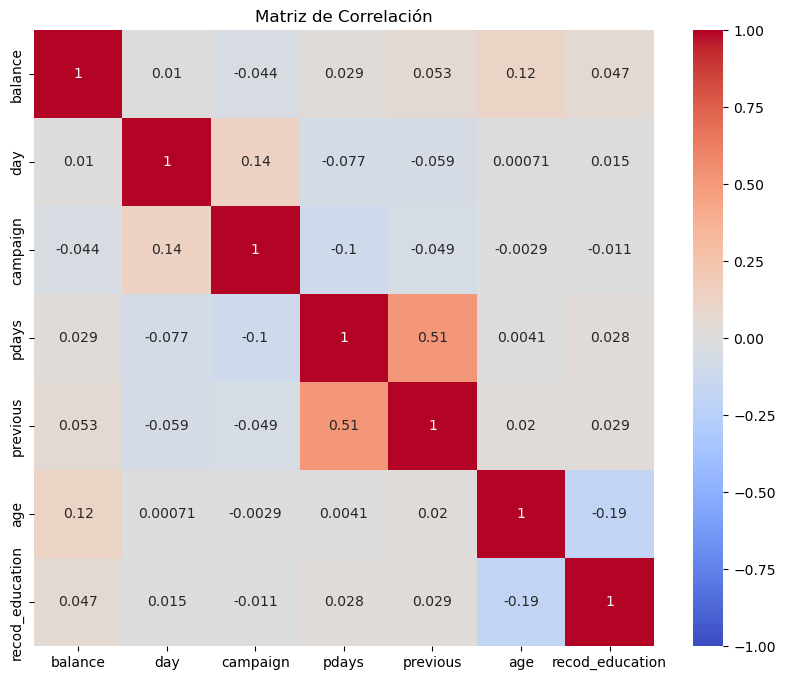

In [369]:
# Calcular la matriu de correlación solo con las variables numéricas
#correlation = df_bank[columnas_numericas].corr(numeric_only=True) #No em cal numeric_only=True doncs totes són numèriques
correlation = df_bank[columnas_numericas].corr()

#Visualitzar la matriu de correlació con un mapa de calor
plt.figure(figsize=(10, 8))
sns.heatmap(correlation, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
plt.title('Matriz de Correlación')
plt.show()

Como vemos que existe una correlación moderada entre pdays y previous, y pdays tienen una significancia muy similar con Mann-Whitney, quitaremos pdays de la selección.
El motivo es que pdays=-1 hace más ruido que previous=0. De momento de numéricas nos quedaremos con: 
- **previous**

- **balance**

- **campaign**

### 3.4 Dataset con las varias preseleccionadas

In [370]:
columns_selected=['cat_poutcome','housing','previous','balance','campaign','deposit']
df_bank_sel=df_bank[columns_selected].copy()
df_bank_sel.head()

,cat_poutcome,housing,previous,balance,campaign,deposit
0,other,1,0,2343,1,1
1,other,0,0,45,1,1
2,other,1,0,1270,1,1
3,other,1,0,2476,1,1
4,other,0,0,184,2,1


### 3.5 Label-encoding de las variables categóricas a numéricas

Con las variables escogidas, no haría falta hacer nada

### 3.6 Método One-Hot-Encoding de poutcome

In [371]:
df_encoded_poutcome = pd.get_dummies(df_bank_sel, columns=["cat_poutcome"],drop_first=False)
df_encoded_poutcome=df_encoded_poutcome.drop(columns=['cat_poutcome_other'])
df_encoded_poutcome.head()

,housing,previous,balance,campaign,deposit,cat_poutcome_failure,cat_poutcome_success
0,1,0,2343,1,1,False,False
1,0,0,45,1,1,False,False
2,1,0,1270,1,1,False,False
3,1,0,2476,1,1,False,False
4,0,0,184,2,1,False,False


Ahora ya podemos crear nuestro dataset X y nuestro dataset Y. Solo faltará separar los grupos de entrenamiento.

In [372]:
X=df_encoded_poutcome.drop(columns=['deposit'])
X

,housing,previous,balance,campaign,cat_poutcome_failure,cat_poutcome_success
0,1,0,2343,1,False,False
1,0,0,45,1,False,False
2,1,0,1270,1,False,False
3,1,0,2476,1,False,False
4,0,0,184,2,False,False
...,...,...,...,...,...,...
10645,1,0,1,1,False,False
10646,0,0,733,4,False,False
10647,0,0,29,2,False,False
10648,0,5,0,2,True,False


In [373]:
y=df_bank_sel['deposit'].copy()

## 4 Dividir los datos en Entrenamiento y Test

In [374]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test= train_test_split(X,  y, test_size=0.2, random_state=22)

X_train.to_csv('X_bank_train.csv', index=False)
X_test.to_csv('X_bank_test.csv', index=False)   
y_train.to_csv('y_bank_train.csv', index=False)
y_test.to_csv('y_bank_test.csv', index=False)


Para tener más datos de entrenamiento, consideraremos entrenar el modelo con un 80% de las filas del DataFrame X, que tenía 10650 filas

### 5 Escalar y normalizar las variables numéricas de X_train e X_test

Las variables numéricas hemos considerado que eran: **previous, balance y campaign**

In [375]:
from sklearn.preprocessing import StandardScaler

# Estandarizaremos únicamente las variables numéricas
column_numeric=['previous','balance','campaign']
column_categoric=['housing','cat_poutcome_failure','cat_poutcome_success']
scaler = StandardScaler()

#Para los datos de ENTRENAMIENTO
X_train_num_scaled= scaler.fit_transform(X_train[column_numeric])
X_train_num_scaled_pd=pd.DataFrame(X_train_num_scaled,columns=column_numeric,index=X_train.index)
#Ahora concatenamos las variables estandarizadas numéricas con las variables categóricas que no teníamos que aplicar escalado
X_train_scaled_aux=pd.concat(
   [X_train_num_scaled_pd, X_train[column_categoric]],
   axis=1)
#Tenemos que convertir X_train_scaled_aux a variable numpy.array ya que sinó no funcionaría el algoritmo de regresión logística
X_train_scaled=X_scaled_aux.to_numpy()

#Para los datos de TEST
X_test_num_scaled= scaler.fit_transform(X_test[column_numeric])
X_test_num_scaled_pd=pd.DataFrame(X_test_num_scaled,columns=column_numeric,index=X_test.index)
#Ahora concatenamos las variables estandarizadas numéricas con las variables categóricas que no teníamos que aplicar escalado
X_test_scaled_aux=pd.concat(
   [X_test_num_scaled_pd, X_test[column_categoric]],
   axis=1)
#Tenemos que convertir X_test_scaled_aux a variable numpy.array ya que sinó no funcionaría el algoritmo de regresión logística
X_test_scaled=X_test_scaled_aux.to_numpy()


El DataFrame en pandas con las variables numéricas escaladas y normalizadas de X_train es:

In [376]:
X_train_scaled_aux

,previous,balance,campaign,housing,cat_poutcome_failure,cat_poutcome_success
1549,-0.380203,0.744142,0.561456,0,False,False
6463,-0.380203,-0.531533,-0.568529,0,False,False
6077,-0.380203,0.364186,-0.568529,1,False,False
9257,-0.380203,0.653606,0.184794,1,False,False
421,-0.380203,-0.722995,0.184794,0,False,False
...,...,...,...,...,...,...
4587,0.551175,0.989779,-0.568529,1,False,False
6646,-0.380203,0.439880,-0.191868,1,False,False
5478,-0.380203,0.432459,-0.568529,1,False,False
8548,-0.380203,1.780860,0.938118,1,False,False


El DataFrame en pandas con las variables numéricas escaladas y normalizadas de X_test es:

In [377]:
X_test_scaled_aux

,previous,balance,campaign,housing,cat_poutcome_failure,cat_poutcome_success
7190,-0.315932,-1.021889,-0.178524,1,False,False
2255,-0.315932,-0.755582,-0.178524,0,False,False
10159,-0.315932,-0.543698,0.186405,0,False,False
6119,-0.315932,-0.731637,0.551333,1,False,False
9154,-0.315932,-0.738167,0.551333,1,False,False
...,...,...,...,...,...,...
5517,-0.315932,-0.723655,-0.543452,0,False,False
5258,-0.315932,-0.706965,0.551333,1,False,False
1953,1.517681,3.434218,0.551333,1,False,False
1567,-0.315932,-0.744698,-0.543452,1,False,False


Todas las variables numéricas escaladas y normalizadas tienen desviación estándard 1 y media 0 como tiene que ser

In [378]:
X_train_num_scaled_pd.describe()

,previous,balance,campaign
count,8.520000e+03,8.520000e+03,8.520000e+03
mean,2.856348e-17,-6.671763e-18,-2.043227e-17
std,1.000059e+00,1.000059e+00,1.000059e+00
min,-3.802033e-01,-3.025741e+00,-5.685294e-01
25%,-3.802033e-01,-6.769849e-01,-5.685294e-01
50%,-3.802033e-01,-3.868226e-01,-1.918676e-01
75%,8.548562e-02,3.111253e-01,1.847942e-01
max,1.824735e+01,4.026464e+00,1.525126e+01


In [379]:
X_test_num_scaled_pd.describe()

,previous,balance,campaign
count,2.130000e+03,2.130000e+03,2.130000e+03
mean,-1.667941e-18,6.671763e-18,-3.335881e-17
std,1.000235e+00,1.000235e+00,1.000235e+00
min,-3.159324e-01,-2.411475e+00,-5.434523e-01
25%,-3.159324e-01,-6.763071e-01,-5.434523e-01
50%,-3.159324e-01,-4.014739e-01,-1.785237e-01
75%,5.079022e-02,3.276051e-01,1.864048e-01
max,2.095398e+01,3.865243e+00,1.478355e+01


Ahora con X_train_scaled y y_train ya podríamos entrenar el modelo de regresión logística, que lo haremos en el Sprint 8.


In [380]:
X_train_scaled

array([[-0.2937521346879711, 1.2585204965676347, False, ..., False,
        False, True],
       [-0.2937521346879711, 1.2585204965676347, False, ..., False,
        False, True],
       [-0.2937521346879711, 0.03982225248277294, False, ..., False,
        False, True],
       ...,
       [-0.2937521346879711, -1.1788759916020888, False, ..., False,
        False, True],
       [-0.2937521346879711, 0.03982225248277294, False, ..., False,
        False, True],
       [-0.2937521346879711, -1.1788759916020888, False, ..., False,
        False, True]], dtype=object)

In [381]:
y_train

1549    1
6463    0
6077    0
9257    0
421     1
       ..
4587    1
6646    0
5478    0
8548    0
6276    0
Name: deposit, Length: 8520, dtype: int64